# Part I - Loan Data from Prosper Exploration
## by Agustin Barto

In [1]:
import calendar

from pathlib import Path
from urllib import request
from zipfile import ZipFile

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns  # We've used the traditional namespace instead of "sb"
from IPython.display import display, Markdown, HTML

%matplotlib inline

## Table of Contents

* [Introduction](#introduction)
* [Preliminary Wrangling](#preliminary-wrangling)
    * [Data Dictionary](#data-dictionary)
    * [Downloading the dataset](#downloading-dataset)
    * [Loading the dataset](#loading-dataset)
    * [What is the structure of your dataset?](#structure-dataset)
    * [What is/are the main feature(s) of interest in your dataset?](#features-interest)
        * [``ListingCreationDate``, ``LoanOriginationDate``](#listing-creation-date)
        * [``CreditGrade``, ``ProsperRating (Alpha)``](#credit-grade)
        * [``Term``](#term)
        * [``LoanStatus``](#loan-status)
        * [``BorrowerAPR``, ``BorrowerRate``](#borrower-apr)
        * [``LenderYield``](#lender-yield)
        * [``ListingCategory (numeric)``](#listing-category-numeric)
        * [``Occupation``](#occupation)
        * [``EmploymentStatus``, ``EmploymentStatusDuration``](#employment-status)
        * [``IsBorrowerHomeowner``](#is-borrower-homeowner)
        * [``DebtToIncomeRatio``](#debt-to-income-ratio)
        * [``IncomeRange``](#income-range)
        * [``LoanOriginalAmount``](#loan-original-amount)
    * [What features in the dataset do you think will help support your investigation into your feature(s) of interest?](#support-features)
* [Univariate Exploration](#univariate-exploration)
* [Bivariate Exploration](#bivariate-exploration)

## Introduction<a class="anchor" id="introduction"></a>

I've chosen the "Loan Data from Prosper" dataset as it strikes a good balance between size, complexity and richness. It has a lot of variables to chose from, both numerical and categorical and enough samples to provided meaningful results.

As we'll show in the following section, the data set contains quite a lot of columns to chose from. During the wrangling process we'll briefly explore the dataset to decide which columns are going to be the focus of the analysis. Whenever needed, the column definition will be expanded with external sources.

## Preliminary Wrangling<a class="anchor" id="preliminary-wrangling"></a>

### Data dictionary<a class="anchor" id="data-dictionary"></a>

 The following table (converted to CSV from the original [Google sheet](https://docs.google.com/spreadsheets/d/1gDyi_L4UvIrLTEC6Wri5nbaMmkGmLQBk-Yx3z0XDEtI/edit#gid=0)) contains a brief description of each column:

In [2]:
variable_definitions_df = pd.read_csv(
    "https://docs.google.com/spreadsheets/d/1gDyi_L4UvIrLTEC6Wri5nbaMmkGmLQBk-Yx3z0XDEtI/export?format=csv",
)

In [3]:
styler = variable_definitions_df\
    .style\
    .set_properties(
        **{'text-align': 'left'}
    )\
    .hide(axis="index")
display(HTML(styler.to_html()))

Variable,Description
ListingKey,"Unique key for each listing, same value as the 'key' used in the listing object in the API."
ListingNumber,The number that uniquely identifies the listing to the public as displayed on the website.
ListingCreationDate,The date the listing was created.
CreditGrade,The Credit rating that was assigned at the time the listing went live. Applicable for listings pre-2009 period and will only be populated for those listings.
Term,The length of the loan expressed in months.
LoanStatus,"The current status of the loan: Cancelled, Chargedoff, Completed, Current, Defaulted, FinalPaymentInProgress, PastDue. The PastDue status will be accompanied by a delinquency bucket."
ClosedDate,"Closed date is applicable for Cancelled, Completed, Chargedoff and Defaulted loan statuses."
BorrowerAPR,The Borrower's Annual Percentage Rate (APR) for the loan.
BorrowerRate,The Borrower's interest rate for this loan.
LenderYield,The Lender yield on the loan. Lender yield is equal to the interest rate on the loan less the servicing fee.


### Downloading the dataset<a class="anchor" id="downloading-dataset"></a>

We assume the dataset has been included with the submission, but in case it had to be removed due to size constraints, the following cell checks if the data is available and downloads it if it is not.

In [4]:
prosper_load_data_csv_zip = Path("./prosperLoanData.csv.zip")

In [5]:
def download_compress_dataset():
    try:
        with request.urlopen("https://s3.amazonaws.com/udacity-hosted-downloads/ud651/prosperLoanData.csv") as f:
            with ZipFile(prosper_load_data_csv_zip, "w") as zf:
                with zf.open("prosperLoanData.csv", "w") as g:
                    g.write(f.read())
    except Exception as e:
        display(Markdown(f"> <span style='color: red;'>**Exception raised retrieving data set:**</span> {e}"))
        prosper_load_data_csv_zip.unlink()

In [6]:
if not prosper_load_data_csv_zip.exists():
    download_compress_dataset()

### Loading the dataset<a class="anchor" id="loading-dataset"></a>

Once the dataset has been downloaded (and compressed), pandas can just read the CSV file straight out of the zip file:

In [7]:
prosper_load_data_df = pd.read_csv(prosper_load_data_csv_zip)

### What is the structure of your dataset?<a class="anchor" id="structure-dataset"></a>

In [8]:
prosper_load_data_df.sample(5)

,ListingKey,ListingNumber,ListingCreationDate,CreditGrade,Term,LoanStatus,ClosedDate,BorrowerAPR,BorrowerRate,LenderYield,...,LP_ServiceFees,LP_CollectionFees,LP_GrossPrincipalLoss,LP_NetPrincipalLoss,LP_NonPrincipalRecoverypayments,PercentFunded,Recommendations,InvestmentFromFriendsCount,InvestmentFromFriendsAmount,Investors
102893,0D16337340168380375E6C1,56773,2006-11-03 13:04:53.360000000,C,36,Completed,2008-01-18 00:00:00,0.18726,0.1800,0.1700,...,-60.01,0.0,0.0,0.0,0.0,1.0,0,0,0.0,122
8353,DE4F336720079620468017E,32590,2006-08-19 14:40:59.490000000,E,36,Chargedoff,2008-07-30 00:00:00,0.26159,0.2540,0.2490,...,-30.87,0.0,2985.3,2985.3,0.0,1.0,0,0,0.0,59
85330,6FFF359383434130635EB99,996859,2013-11-15 12:37:17.467000000,NaN,36,Current,NaN,0.13799,0.1099,0.0999,...,-29.52,0.0,0.0,0.0,0.0,1.0,0,0,0.0,142
8563,9BB335781369761840F507C,775853,2013-05-11 13:36:33.713000000,NaN,36,Current,NaN,0.06998,0.0666,0.0566,...,-135.83,0.0,0.0,0.0,0.0,1.0,0,0,0.0,427
72264,DFEC35964480329518887DC,1076400,2013-12-10 05:30:12.303000000,NaN,60,Current,NaN,0.20040,0.1765,0.1665,...,-42.25,0.0,0.0,0.0,0.0,1.0,0,0,0.0,1


We've used ``sample()`` instead of ``head()`` as some features of the dataset might be hidden by a specific ordering of rowsm.

In [9]:
prosper_load_data_df.shape

(113937, 81)

In [10]:
prosper_load_data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 113937 entries, 0 to 113936
Data columns (total 81 columns):
 #   Column                               Non-Null Count   Dtype  
---  ------                               --------------   -----  
 0   ListingKey                           113937 non-null  object 
 1   ListingNumber                        113937 non-null  int64  
 2   ListingCreationDate                  113937 non-null  object 
 3   CreditGrade                          28953 non-null   object 
 4   Term                                 113937 non-null  int64  
 5   LoanStatus                           113937 non-null  object 
 6   ClosedDate                           55089 non-null   object 
 7   BorrowerAPR                          113912 non-null  float64
 8   BorrowerRate                         113937 non-null  float64
 9   LenderYield                          113937 non-null  float64
 10  EstimatedEffectiveYield              84853 non-null   float64
 11  EstimatedLoss

The dataset is comprised of 113937 rows (loans) and 81 columns. The purpose of each column is described in the [data dictionary](#section). Before we delve into the contents, we need to make sure certain basic data hygiene criteria are met. Are there any duplicate rows?

In [11]:
prosper_load_data_df.duplicated().sum()

0

Are there multiple records with the same ``ListingKey`` values?

In [12]:
prosper_load_data_df.ListingKey.duplicated().sum()

871

There are entries with the same ``ListingKey``. Let's explore this records to determine whether we need to drop the duplicates or not.

In [13]:
prosper_load_data_df[
    prosper_load_data_df.ListingKey.duplicated(keep=False)  # Keep duplicates to expose the problem
].sort_values("ListingKey").head(10)

,ListingKey,ListingNumber,ListingCreationDate,CreditGrade,Term,LoanStatus,ClosedDate,BorrowerAPR,BorrowerRate,LenderYield,...,LP_ServiceFees,LP_CollectionFees,LP_GrossPrincipalLoss,LP_NetPrincipalLoss,LP_NonPrincipalRecoverypayments,PercentFunded,Recommendations,InvestmentFromFriendsCount,InvestmentFromFriendsAmount,Investors
32680,00223594917038064A7C947,998257,2013-11-15 16:58:37.167000000,NaN,36,Current,NaN,0.23540,0.1980,0.1880,...,-12.34,0.0,0.0,0.0,0.0,1.0,0,0,0.0,1
32681,00223594917038064A7C947,998257,2013-11-15 16:58:37.167000000,NaN,36,Current,NaN,0.23540,0.1980,0.1880,...,-12.34,0.0,0.0,0.0,0.0,1.0,0,0,0.0,1
32964,00473590513960687DD308F,941296,2013-10-07 15:47:36.023000000,NaN,60,Current,NaN,0.22242,0.1980,0.1880,...,-73.12,0.0,0.0,0.0,0.0,1.0,0,0,0.0,1
17274,00473590513960687DD308F,941296,2013-10-07 15:47:36.023000000,NaN,60,Current,NaN,0.22242,0.1980,0.1880,...,-73.12,0.0,0.0,0.0,0.0,1.0,0,0,0.0,1
7478,0098360461900952056DB93,1190614,2014-03-02 14:21:39.583000000,NaN,36,Current,NaN,0.29660,0.2574,0.2474,...,0.00,0.0,0.0,0.0,0.0,1.0,0,0,0.0,1
33220,0098360461900952056DB93,1190614,2014-03-02 14:21:39.583000000,NaN,36,Current,NaN,0.29660,0.2574,0.2474,...,0.00,0.0,0.0,0.0,0.0,1.0,0,0,0.0,1
27677,01163604029146842E28D9C,1233732,2014-02-25 14:33:39.830000000,NaN,36,Current,NaN,0.31975,0.2800,0.2700,...,0.00,0.0,0.0,0.0,0.0,1.0,0,0,0.0,1
788,01163604029146842E28D9C,1233732,2014-02-25 14:33:39.830000000,NaN,36,Current,NaN,0.31975,0.2800,0.2700,...,0.00,0.0,0.0,0.0,0.0,1.0,0,0,0.0,1
27360,014F35910923350802E1B29,930618,2013-09-26 16:44:24.163000000,NaN,60,Current,NaN,0.19323,0.1695,0.1595,...,-27.50,0.0,0.0,0.0,0.0,1.0,0,0,0.0,1
18324,014F35910923350802E1B29,930618,2013-09-26 16:44:24.163000000,NaN,60,Current,NaN,0.19323,0.1695,0.1595,...,-27.50,0.0,0.0,0.0,0.0,1.0,0,0,0.0,1


From these sample, we can assume that there are all duplicated entries which can be safely removed. Notice that we've copied the original dataframe onto a new variable ``prosper_load_data_clean_df`` to keep the original data as reference.

In [14]:
prosper_load_data_clean_df = prosper_load_data_df.copy()

In [15]:
prosper_load_data_clean_df = prosper_load_data_clean_df[~prosper_load_data_clean_df.ListingKey.duplicated()]

In [16]:
prosper_load_data_clean_df.shape

(113066, 81)

Now we're left with 113066 rows. Additional clean-up might be performed on the next section where we have to analyze the contents of the chosen columns.

### What is/are the main feature(s) of interest in your dataset?<a class="anchor" id="features-interest"></a>

The initial set of columns of our interest is the following (you can check the [data dictionary](#data-dictionary) for an explanation of each column):

* ``ListingCreationDate``
* ``CreditGrade``
* ``Term``
* ``LoanStatus``
* ``BorrowerAPR``
* ``BorrowerRate``
* ``LenderYield``
* ``ProsperRating (Alpha)``
* ``ListingCategory (numeric)``
* ``Occupation``
* ``EmploymentStatus``
* ``EmploymentStatusDuration``
* ``IsBorrowerHomeowner``
* ``DebtToIncomeRatio``
* ``IncomeRange``
* ``LoanOriginalAmount``
* ``LoanOriginationDate``

This set of columns was chosen with the idea of analyzing the influence of socio-economic and financial factors on multiple aspects of the loans:

* Which are the most popular loan categories?
* How many borrowers are home owners?
* How are the borrower APR, borrower rate and lender yield related to each other?
* How does the employment status, occupation, home ownership, credit grades, income range and debt to income ratio affect the APR?
* Is there a relationship between the loan amount and the income range?
* How did the loans fared over the years. Is the 2008 global crisis represented?
* Are there specific period with higher activity than others?
* Does the income range influence the chances of defaulting?

As expected, other questions might arise during the analysis and limitationos of the dataset might force us to drop some of these.

Before we can proceed with the analysis, we need to explore each column to determine whether its contents or structure are appropriate for our needs, and if they aren't, can they be adapted or do we need to exclude them?

#### ``ListingCreationDate``, ``LoanOriginationDate``<a class="anchor" id="listing-creation-date"></a>

In [17]:
prosper_load_data_clean_df[[
    "ListingCreationDate",
    "LoanOriginationDate"
]].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 113066 entries, 0 to 113936
Data columns (total 2 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   ListingCreationDate  113066 non-null  object
 1   LoanOriginationDate  113066 non-null  object
dtypes: object(2)
memory usage: 2.6+ MB


In [18]:
prosper_load_data_clean_df[[
    "ListingCreationDate",
    "LoanOriginationDate"
]].sample(5)

,ListingCreationDate,LoanOriginationDate
96420,2013-03-18 20:02:49.707000000,2013-03-27 00:00:00
19523,2008-04-11 12:35:30.650000000,2008-04-22 00:00:00
68783,2012-04-20 19:08:49.013000000,2012-04-26 00:00:00
51705,2014-01-13 09:29:31.617000000,2014-01-16 00:00:00
65894,2013-01-18 08:25:22.463000000,2013-02-01 00:00:00


These two columns represent dates, with ``ListingCreationDate`` in particular also containing time information, but are stored as strings. Before we can continue, we should convert these columns to ``datetime64`` using pandas' ``to_datetime``.

In [19]:
prosper_load_data_clean_df["ListingCreationDate"] = pd.to_datetime(
    prosper_load_data_clean_df.ListingCreationDate
)
prosper_load_data_clean_df["LoanOriginationDate"] = pd.to_datetime(
    prosper_load_data_clean_df.LoanOriginationDate
)

In [20]:
prosper_load_data_clean_df[[
    "ListingCreationDate",
    "LoanOriginationDate"
]].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 113066 entries, 0 to 113936
Data columns (total 2 columns):
 #   Column               Non-Null Count   Dtype         
---  ------               --------------   -----         
 0   ListingCreationDate  113066 non-null  datetime64[ns]
 1   LoanOriginationDate  113066 non-null  datetime64[ns]
dtypes: datetime64[ns](2)
memory usage: 2.6 MB


Let's now focus on the contents of these columns.

In [21]:
display(Markdown(f"""\
| Column | Min | Max |
|--------|-----|-----|
| ``ListingCreationDate`` | {prosper_load_data_clean_df.ListingCreationDate.min()} | {prosper_load_data_clean_df.ListingCreationDate.max()} |
| ``LoanOriginationDate`` | {prosper_load_data_clean_df.LoanOriginationDate.min()} | {prosper_load_data_clean_df.LoanOriginationDate.max()} |
"""))

| Column | Min | Max |
|--------|-----|-----|
| ``ListingCreationDate`` | 2005-11-09 20:44:28.847000 | 2014-03-10 12:20:53.760000 |
| ``LoanOriginationDate`` | 2005-11-15 00:00:00 | 2014-03-12 00:00:00 |


This means that our dataset goes from November 2005 until March 2014.

#### ``CreditGrade``, ``ProsperRating (Alpha)``<a class="anchor" id="credit-grade"></a>

According to the [data dictionary](#data-dictionary), ``CreditGrade`` will only be populated for loans prior to 2009, while ``ProsperRating (Alpha)`` will be available for deals from 2009 onwards. This situation will make any global analysis on these columns impossible, it might be interesting to analyse each period in isolation or to perform a comparison between the two variables.

In [22]:
prosper_load_data_clean_df.CreditGrade.isna().sum()

84113

In [23]:
prosper_load_data_clean_df.CreditGrade.value_counts()

C     5649
D     5153
B     4389
AA    3509
HR    3508
A     3315
E     3289
NC     141
Name: CreditGrade, dtype: int64

According to Prosper's [API documentation](https://www.prosper.com/Downloads/Services/Documentation/ProsperAPI_Objects_Details.html) this is a categorial column with the following scale:

1. NC
2. HR
3. E
4. D
5. C
6. B
7. A
8. AA

In [24]:
prosper_load_data_clean_df["ProsperRating (Alpha)"].isna().sum()

29084

In [25]:
prosper_load_data_clean_df["ProsperRating (Alpha)"].value_counts()

C     18096
B     15368
A     14390
D     14170
E      9716
HR     6917
AA     5325
Name: ProsperRating (Alpha), dtype: int64

According to Prosper's [API documentation](https://www.prosper.com/Downloads/Services/Documentation/ProsperAPI_Objects_Details.html) and the following [article](https://www.prosper.com/invest/how-to-invest/prosper-ratings/?mod=article_inline) this is a categorial column with the following scale:

1. NA
2. HR
3. E
4. D
5. C
6. B
7. A
9. AA

Although there seems to be a correspondence between values, we cannot assume these columns are compatible, so they will be kept separate. Given that these are ordinal categorical values, we should convert them accordingly.

In [26]:
prosper_load_data_clean_df["CreditGrade"] = prosper_load_data_clean_df.CreditGrade.astype(
    pd.CategoricalDtype(ordered=True, categories=[
        "NC",
        "HR",
        "E",
        "D",
        "C",
        "B",
        "A",
        "AA"
    ])
)
prosper_load_data_clean_df["ProsperRating (Alpha)"] = prosper_load_data_clean_df[
    "ProsperRating (Alpha)"
].astype(
    pd.CategoricalDtype(ordered=True, categories=[
        "NA",
        "HR",
        "E",
        "D",
        "C",
        "B",
        "A",
        "AA"
    ])
)

In [27]:
prosper_load_data_clean_df[[
    "CreditGrade",
    "ProsperRating (Alpha)"
]].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 113066 entries, 0 to 113936
Data columns (total 2 columns):
 #   Column                 Non-Null Count  Dtype   
---  ------                 --------------  -----   
 0   CreditGrade            28953 non-null  category
 1   ProsperRating (Alpha)  83982 non-null  category
dtypes: category(2)
memory usage: 1.1 MB


Are there any loands without values for either of these columns?

In [28]:
(
    prosper_load_data_clean_df.CreditGrade.isna()
    & prosper_load_data_clean_df["ProsperRating (Alpha)"].isna()
).sum()

131

We're to drop these rows as we think these variables are essential for our analysis.

In [29]:
prosper_load_data_clean_df = prosper_load_data_clean_df[
    (~prosper_load_data_clean_df.CreditGrade.isna())
    | (~prosper_load_data_clean_df["ProsperRating (Alpha)"].isna())
]

In [30]:
(
    prosper_load_data_clean_df.CreditGrade.isna()
    & prosper_load_data_clean_df["ProsperRating (Alpha)"].isna()
).sum()

0

#### ``Term``<a class="anchor" id="term"></a>

In [31]:
prosper_load_data_clean_df.Term.nunique()

3

In [32]:
prosper_load_data_clean_df.Term.value_counts()

36    87094
60    24228
12     1613
Name: Term, dtype: int64

Given that we're only seeing three possible values for the ``Term`` column, we could be tempted to convert it to a categorical type, but since the documentation clearly states that these are to be interpreted as months, we shouldn't convert it.

In [33]:
prosper_load_data_clean_df.Term.isna().sum()

0

There are no loans without a ``Term`` value.

#### ``LoanStatus``<a class="anchor" id="loan-status"></a>

In [34]:
prosper_load_data_clean_df.LoanStatus.nunique()

12

In [35]:
prosper_load_data_clean_df.LoanStatus.value_counts()

Current                   55730
Completed                 37939
Chargedoff                11986
Defaulted                  5015
Past Due (1-15 days)        800
Past Due (31-60 days)       361
Past Due (61-90 days)       311
Past Due (91-120 days)      304
Past Due (16-30 days)       265
FinalPaymentInProgress      203
Past Due (>120 days)         16
Cancelled                     5
Name: LoanStatus, dtype: int64

Are there any loans without a ``LoanStatus`` value?

In [36]:
prosper_load_data_clean_df.LoanStatus.isna().sum()

0

According to the documentation, this column violates the Tidy Data principle of one variable per column is it contains both the load status and the delinquency bucket:

> The current status of the loan: Cancelled, Chargedoff, Completed, Current, Defaulted, FinalPaymentInProgress, PastDue. The PastDue status will be accompanied by a delinquency bucket.

We're going to convert ``LoanStatus`` to a categorical type and move the delinquency bucket into its own categorical column named ``DelinquencyBucket``.

In [37]:
(
    prosper_load_data_clean_df[
        # Match loans where the LoanStatus column starts with "Past Due"
        prosper_load_data_clean_df.LoanStatus.str.match(r"^Past Due.*$")
    ]
).LoanStatus.str.extract(
    # Extract the past due period with a capturing group
    r"^Past Due \((.*) days\)$"
).value_counts()

1-15      800
31-60     361
61-90     311
91-120    304
16-30     265
>120       16
dtype: int64

In [38]:
# Create a new DelinquencyBucket string column
prosper_load_data_clean_df["DelinquencyBucket"] = (
    prosper_load_data_clean_df[prosper_load_data_clean_df.LoanStatus.str.match(r"^Past Due.*")]
).LoanStatus.str.extract(r"^Past Due \((.*) days\)$")

In [39]:
# Convert the DelinquencyBucket to an ordinal category
prosper_load_data_clean_df["DelinquencyBucket"] = prosper_load_data_clean_df.DelinquencyBucket.astype(
    pd.CategoricalDtype(
        ordered=True,
        categories=[
            "1-15",
            "16-30",
            "31-60",
            "61-90",
            "91-120",
            ">120"
        ]
    )
)

In [40]:
prosper_load_data_clean_df.DelinquencyBucket.info()

<class 'pandas.core.series.Series'>
Int64Index: 112935 entries, 0 to 113936
Series name: DelinquencyBucket
Non-Null Count  Dtype   
--------------  -----   
2057 non-null   category
dtypes: category(1)
memory usage: 992.8 KB


Now we can remove the delinquency bucket info from the past due loans.

In [41]:
# Create a new LoanStatus column extracting the status while dropping the delinquency bucket
prosper_load_data_clean_df["LoanStatus"] = prosper_load_data_clean_df.LoanStatus.str.extract(
    r"^(Current|Completed|Chargedoff|Defaulted|Past Due|FinalPaymentInProgress|Cancelled).*"
)

In [42]:
prosper_load_data_clean_df["LoanStatus"].value_counts()

Current                   55730
Completed                 37939
Chargedoff                11986
Defaulted                  5015
Past Due                   2057
FinalPaymentInProgress      203
Cancelled                     5
Name: LoanStatus, dtype: int64

Notice that the value counts match those shown above. Now we can safely convert the column to a nominal categorical type.

In [43]:
prosper_load_data_clean_df["LoanStatus"] = prosper_load_data_clean_df.LoanStatus.astype(
    pd.CategoricalDtype(
        ordered=False,
        categories=[
            "Current",
            "Completed",
            "Chargedoff",
            "Defaulted",
            "FinalPaymentInProgress",
            "Past Due",
            "Cancelled"
        ]
    )
)

In [44]:
prosper_load_data_clean_df.LoanStatus.info()

<class 'pandas.core.series.Series'>
Int64Index: 112935 entries, 0 to 113936
Series name: LoanStatus
Non-Null Count   Dtype   
--------------   -----   
112935 non-null  category
dtypes: category(1)
memory usage: 992.9 KB


In [45]:
prosper_load_data_clean_df.LoanStatus.isna().sum()

0

#### ``BorrowerAPR``, ``BorrowerRate``<a class="anchor" id="borrower-apr"></a>

According to the data dictionary, ``BorrowerAPR`` is the Borrower's Annual Percentage Rate (APR) for the loan.
while ``BorrowerRate`` is the borrower's interest rate for this loan. According to [this article](https://www.rocketmortgage.com/learn/comparing-mortgage-options-apr-vs-interest-rate), there is a clear relationship between this variables, but we'll explore it in detail. Let's see how much data is available for these variables.

In [46]:
prosper_load_data_clean_df.BorrowerAPR.isna().sum()

25

In [47]:
prosper_load_data_clean_df.BorrowerRate.isna().sum()

0

We're going to drop rows without a ``BorrowerAPR`` or ``BorrowerRate`` values:

In [48]:
prosper_load_data_clean_df = prosper_load_data_clean_df[
    ~(
        prosper_load_data_clean_df.BorrowerAPR.isna()
        & prosper_load_data_clean_df.BorrowerRate.isna()
    )
]

In [49]:
prosper_load_data_clean_df.BorrowerAPR.describe()

count    112910.000000
mean          0.219018
std           0.080464
min           0.006530
25%           0.156290
50%           0.209860
75%           0.283860
max           0.512290
Name: BorrowerAPR, dtype: float64

In [50]:
prosper_load_data_clean_df.BorrowerRate.describe()

count    112935.000000
mean          0.192980
std           0.074899
min           0.000000
25%           0.134000
50%           0.184000
75%           0.250600
max           0.497500
Name: BorrowerRate, dtype: float64

#### ``LenderYield``<a class="anchor" id="lender-yield"></a>

``LenderYield`` is the other side of the coin of ``BorrowerAPR`` and ``BorrowerRate``. Let's see if there's anything to do with this variable.

In [51]:
prosper_load_data_clean_df.LenderYield.isna().sum()

0

In [52]:
prosper_load_data_clean_df.LenderYield.describe()

count    112935.000000
mean          0.182917
std           0.074595
min          -0.010000
25%           0.124600
50%           0.174000
75%           0.240600
max           0.492500
Name: LenderYield, dtype: float64

#### ``ListingCategory (numeric)``<a class="anchor" id="listing-category-numeric"></a>

According to the dictionary, ``ListingCategory (numeric)`` is a categorial variable:

> The category of the listing that the borrower selected when posting their listing: 0 - Not Available, 1 - Debt Consolidation, 2 - Home Improvement, 3 - Business, 4 - Personal Loan, 5 - Student Use, 6 - Auto, 7- Other, 8 - Baby&Adoption, 9 - Boat, 10 - Cosmetic Procedure, 11 - Engagement Ring, 12 - Green Loans, 13 - Household Expenses, 14 - Large Purchases, 15 - Medical/Dental, 16 - Motorcycle, 17 - RV, 18 - Taxes, 19 - Vacation, 20 - Wedding Loans

In [53]:
sorted(prosper_load_data_clean_df["ListingCategory (numeric)"].unique())

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]

We're going to convert these numeric categories into their string counterparts to make it easier to perform analysis and visualizations. We'll create a new categorical typed column named ``ListingCategory``.

In [54]:
listing_categories = [
    "Not Available",       # 0
    "Debt Consolidation",  # 1
    "Home Improvement",    # 2
    "Business",            # 3
    "Personal Loan",       # 4
    "Student Use",         # 5
    "Auto",                # 6
    "Other",               # 7
    "Baby&Adoption",       # 8
    "Boat",                # 9
    "Cosmetic Procedure",  # 10
    "Engagement Ring",     # 11
    "Green Loans",         # 12
    "Household Expenses",  # 13
    "Large Purchases",     # 14
    "Medical/Dental",      # 15
    "Motorcycle",          # 16
    "RV",                  # 17
    "Taxes",               # 18
    "Vacation",            # 19
    "Wedding Loans"        # 20
]

listing_category_value_map = dict(enumerate(listing_categories))
listing_category_value_map

{0: 'Not Available',
 1: 'Debt Consolidation',
 2: 'Home Improvement',
 3: 'Business',
 4: 'Personal Loan',
 5: 'Student Use',
 6: 'Auto',
 7: 'Other',
 8: 'Baby&Adoption',
 9: 'Boat',
 10: 'Cosmetic Procedure',
 11: 'Engagement Ring',
 12: 'Green Loans',
 13: 'Household Expenses',
 14: 'Large Purchases',
 15: 'Medical/Dental',
 16: 'Motorcycle',
 17: 'RV',
 18: 'Taxes',
 19: 'Vacation',
 20: 'Wedding Loans'}

In [55]:
# Create a new ListingCategory column using the listing_category_value_map mapping
prosper_load_data_clean_df["ListingCategory"] =\
    prosper_load_data_clean_df["ListingCategory (numeric)"].apply(
        lambda v: listing_category_value_map[v]
    )

In [56]:
# Convert ListingCategory to a categorical column
prosper_load_data_clean_df["ListingCategory"] = prosper_load_data_clean_df.ListingCategory.astype(
    pd.CategoricalDtype(ordered=False, categories=listing_categories)
)

In [57]:
prosper_load_data_clean_df.ListingCategory.info()

<class 'pandas.core.series.Series'>
Int64Index: 112935 entries, 0 to 113936
Series name: ListingCategory
Non-Null Count   Dtype   
--------------   -----   
112935 non-null  category
dtypes: category(1)
memory usage: 993.3 KB


#### ``Occupation``<a class="anchor" id="occupation"></a>

In [58]:
prosper_load_data_clean_df.Occupation.nunique()

67

In [59]:
prosper_load_data_clean_df.Occupation.value_counts()

Other                          28392
Professional                   13508
Computer Programmer             4433
Executive                       4276
Teacher                         3724
                               ...  
Dentist                           67
Student - College Freshman        41
Student - Community College       28
Judge                             22
Student - Technical School        16
Name: Occupation, Length: 67, dtype: int64

In [60]:
prosper_load_data_clean_df.Occupation.isna().sum()

3529

There are 3529 rows without an ``Occupation`` value.

``Ocupation`` is a categorical variable and has to be converted as such, but given the number of categories, we'll have to be careful when presenting charts that includes it.

In [61]:
prosper_load_data_clean_df["Occupation"] = prosper_load_data_clean_df.Occupation.astype(
    pd.CategoricalDtype(
        ordered=False,
        # Categories sorted alphabetically (but we're not using a sorted category type)
        categories=sorted(
            prosper_load_data_clean_df.Occupation.dropna().unique()
        )
    )
)

#### ``EmploymentStatus``, ``EmploymentStatusDuration``<a class="anchor" id="employment-status"></a>

In [62]:
prosper_load_data_clean_df.EmploymentStatus.unique()

array(['Self-employed', 'Employed', 'Not available', 'Full-time', 'Other',
       nan, 'Not employed', 'Part-time', 'Retired'], dtype=object)

In [63]:
prosper_load_data_clean_df.EmploymentStatus.isna().sum()  # Has missing values

2255

There are 2255 rows without an ``EmploymentStatus`` value. Once again, we'll convert this column into a categorical type.

In [64]:
prosper_load_data_clean_df["EmploymentStatus"] = prosper_load_data_clean_df.EmploymentStatus.astype(
    pd.CategoricalDtype(
        ordered=False,
        # Categories sorted alphabetically (but we're not using a sorted category type)
        categories=sorted(
            prosper_load_data_clean_df.EmploymentStatus.dropna().unique()
        )
    )
)

Since ``EmploymentStatusDuration`` is expressed in number of months, we'll convert the column to ``Int64``.

In [65]:
prosper_load_data_clean_df["EmploymentStatusDuration"] =\
prosper_load_data_clean_df.EmploymentStatusDuration.astype("Int64")

In [66]:
prosper_load_data_clean_df.EmploymentStatusDuration.info()

<class 'pandas.core.series.Series'>
Int64Index: 112935 entries, 0 to 113936
Series name: EmploymentStatusDuration
Non-Null Count   Dtype
--------------   -----
105310 non-null  Int64
dtypes: Int64(1)
memory usage: 1.8 MB


#### ``IsBorrowerHomeowner``<a class="anchor" id="is-borrower-homeowner"></a>

In [67]:
prosper_load_data_clean_df.IsBorrowerHomeowner.nunique()

2

In [68]:
prosper_load_data_clean_df.IsBorrowerHomeowner.value_counts()

True     56987
False    55948
Name: IsBorrowerHomeowner, dtype: int64

In [69]:
prosper_load_data_clean_df.IsBorrowerHomeowner.isna().sum()

0

Since this is clearly a boolean column without any missing values, we'll convert it accordingly.

In [70]:
prosper_load_data_clean_df["IsBorrowerHomeowner"] =\
prosper_load_data_clean_df.IsBorrowerHomeowner.astype("bool")

In [71]:
prosper_load_data_clean_df.IsBorrowerHomeowner.info()

<class 'pandas.core.series.Series'>
Int64Index: 112935 entries, 0 to 113936
Series name: IsBorrowerHomeowner
Non-Null Count   Dtype
--------------   -----
112935 non-null  bool 
dtypes: bool(1)
memory usage: 992.6 KB


#### ``DebtToIncomeRatio``<a class="anchor" id="dept-to-income-ratio"></a>

In [72]:
prosper_load_data_clean_df.DebtToIncomeRatio.sample(5)

22102    0.35
35986    0.29
59543    0.09
9153     0.13
14474    0.29
Name: DebtToIncomeRatio, dtype: float64

In [73]:
prosper_load_data_clean_df.DebtToIncomeRatio.describe()

count    104474.000000
mean          0.276062
std           0.553793
min           0.000000
25%           0.140000
50%           0.220000
75%           0.320000
max          10.010000
Name: DebtToIncomeRatio, dtype: float64

In [74]:
prosper_load_data_clean_df.DebtToIncomeRatio.isna().sum()

8461

There are 8461 rows without a ``DebtToIncomeRatio`` value.

#### ``IncomeRange``<a class="anchor" id="income-range"></a>

In [75]:
prosper_load_data_clean_df.IncomeRange.nunique()

8

In [76]:
prosper_load_data_clean_df.IncomeRange.value_counts()

$25,000-49,999    31900
$50,000-74,999    30704
$100,000+         17172
$75,000-99,999    16763
Not displayed      7741
$1-24,999          7228
Not employed        806
$0                  621
Name: IncomeRange, dtype: int64

We certainly need to convert this column into a categorical type, but there's also the matter of a minor violation of the Tidy Data rules as this column is also representing the employment status for some rows. We've chosen to ignore this violation to simplify the analysis. Given that the number of rows with a value of ``$0`` is so low, we'll drop them from our analysis.

In [77]:
prosper_load_data_clean_df = prosper_load_data_clean_df[prosper_load_data_clean_df.IncomeRange != "$0"]

In [78]:
prosper_load_data_clean_df["IncomeRange"] = prosper_load_data_clean_df.IncomeRange.astype(
    pd.CategoricalDtype(
        ordered=True,
        categories=[
            "Not employed",
            "Not displayed",
            "$1-24,999",
            "$25,000-49,999",
            "$50,000-74,999",
            "$75,000-99,999",
            "$100,000+"
        ]
    )
)

In [79]:
prosper_load_data_clean_df.IncomeRange.info()

<class 'pandas.core.series.Series'>
Int64Index: 112314 entries, 0 to 113936
Series name: IncomeRange
Non-Null Count   Dtype   
--------------   -----   
112314 non-null  category
dtypes: category(1)
memory usage: 987.5 KB


#### ``LoanOriginalAmount``<a class="anchor" id="loan-original-amount"></a>

In [80]:
prosper_load_data_clean_df.LoanOriginalAmount.describe()

count    112314.000000
mean       8324.573784
std        6234.488919
min        1000.000000
25%        4000.000000
50%        6404.500000
75%       12000.000000
max       35000.000000
Name: LoanOriginalAmount, dtype: float64

In [81]:
prosper_load_data_clean_df.LoanOriginalAmount.isna().sum()

0

Nothing needs to be done with this column.

#### Final steps

The last thing to do is to drop the unnecessary columns and to save the dataframe on to a format that allows us to keep the type information so we don't have to reprocess the original dataset each time we want to perform the rest of the exploration steps.

In [82]:
prosper_load_data_clean_df = prosper_load_data_clean_df[[
    "ListingKey",  # Needed to individualize loans
    "ListingCreationDate",
    "CreditGrade",
    "Term",
    "LoanStatus",
    "DelinquencyBucket",
    "ClosedDate",
    "BorrowerAPR",
    "BorrowerRate",
    "LenderYield",
    "ProsperRating (Alpha)",
    "ListingCategory",
    "Occupation",
    "EmploymentStatus",
    "EmploymentStatusDuration",
    "IsBorrowerHomeowner",
    "DebtToIncomeRatio",
    "IncomeRange",
    "LoanOriginalAmount",
    "LoanOriginationDate"
]]

In [83]:
prosper_load_data_clean_df.sample(5)

,ListingKey,ListingCreationDate,CreditGrade,Term,LoanStatus,DelinquencyBucket,ClosedDate,BorrowerAPR,BorrowerRate,LenderYield,ProsperRating (Alpha),ListingCategory,Occupation,EmploymentStatus,EmploymentStatusDuration,IsBorrowerHomeowner,DebtToIncomeRatio,IncomeRange,LoanOriginalAmount,LoanOriginationDate
108674,AADA3545519493003CFD85F,2012-04-25 13:01:04.903,NaN,60,Current,NaN,NaN,0.35838,0.3304,0.3204,E,Debt Consolidation,Clerical,Full-time,235,True,0.16,"$25,000-49,999",4000,2012-05-02
14243,9B573585065949050E02EB2,2013-08-06 18:33:32.390,NaN,36,Current,NaN,NaN,0.28780,0.2492,0.2392,D,Engagement Ring,Computer Programmer,Employed,29,False,0.13,"$75,000-99,999",6000,2013-08-14
20644,173B3590729438100D13E80,2013-09-24 15:57:20.543,NaN,36,Current,NaN,NaN,0.12691,0.0990,0.0890,A,Debt Consolidation,Other,Employed,75,True,0.11,"$25,000-49,999",7000,2013-09-26
19229,580C3392314837067BF25EF,2007-06-22 17:33:03.037,C,36,Completed,NaN,2010-07-19 00:00:00,0.15964,0.1525,0.1375,NaN,Not Available,Other,Full-time,28,False,0.35,"$25,000-49,999",6500,2007-07-05
78638,BF3734309591767214868FD,2008-09-09 22:53:14.940,D,36,Completed,NaN,2011-09-12 00:00:00,0.18386,0.1620,0.1520,NaN,Debt Consolidation,Other,Full-time,4,False,0.29,"$1-24,999",1700,2008-09-12


In [84]:
prosper_load_data_clean_pickle = Path("prosper_load_data_clean.pickle")

In [85]:
prosper_load_data_clean_df.to_pickle(prosper_load_data_clean_pickle)

### What features in the dataset do you think will help support your investigation into your feature(s) of interest?<a class="anchor" id="support-features"></a>

After a few steps of cleanup, this is the final set of columns that will support the rest of our analysis.

* ``ListingCreationDate``
* ``CreditGrade``
* ``Term``
* ``LoanStatus``
* ``DelinquencyBucket`` <span style="color: blue;">(added)</span>
* ``ClosedDate``
* ``BorrowerAPR``
* ``BorrowerRate``
* ``LenderYield``
* ``ProsperRating (Alpha)``
* ``ListingCategory`` <span style="color: blue;">(added)</span>
* ``Occupation``
* ``EmploymentStatus``
* ``EmploymentStatusDuration``
* ``IsBorrowerHomeowner``
* ``DebtToIncomeRatio``
* ``IncomeRange``
* ``LoanOriginalAmount``
* ``LoanOriginationDate``

As part of the wrangling process, we've added two columns:

* ``DelinquencyBucket``: Extracted from ``LoanStatus``, it contains the delinquency bucket for past due loans.
* ``ListingCategory``: Converted from ``ListingCategory (numeric)`` with the information from the data dictionary and the API documentation.

The list of columns/variables can be categorized as follows:

<table>
    <thead>
        <tr>
            <th>Variable</th>
            <th colspan=2 style="text-align:center">Quantitative</th>
            <th colspan=2 style="text-align:center">Categorical</th>
        </tr>
        <tr>
            <th></th>
            <th style="text-align:center">Continuous</th>
            <th style="text-align:center">Discrete</th>
            <th style="text-align:center">Nominal</th>
            <th style="text-align:center">Ordinal</th>
        </tr>
    </thead>
    <tbody>
        <tr>
            <td>ListingCreationDate</td>
            <td style="text-align:center">&#10004;</td>
            <td style="text-align:center"></td>
            <td style="text-align:center"></td>
            <td style="text-align:center"></td>
        </tr>
        <tr>
            <td>CreditGrade</td>
            <td style="text-align:center"></td>
            <td style="text-align:center"></td>
            <td style="text-align:center"></td>
            <td style="text-align:center">&#10004;</td>
        </tr>
        <tr>
            <td>Term</td>
            <td style="text-align:center"></td>
            <td style="text-align:center">&#10004;</td>
            <td style="text-align:center"></td>
            <td style="text-align:center"></td>
        </tr>
        <tr>
            <td>LoanStatus</td>
            <td style="text-align:center"></td>
            <td style="text-align:center"></td>
            <td style="text-align:center">&#10004;</td>
            <td style="text-align:center"></td>
        </tr>
        <tr>
            <td>DelinquencyBucket</td>
            <td style="text-align:center"></td>
            <td style="text-align:center"></td>
            <td style="text-align:center"></td>
            <td style="text-align:center">&#10004;</td>
        </tr>
        <tr>
            <td>BorrowerAPR</td>
            <td style="text-align:center">&#10004;</td>
            <td style="text-align:center"></td>
            <td style="text-align:center"></td>
            <td style="text-align:center"></td>
        </tr>
        <tr>
            <td>BorrowerRate</td>
            <td style="text-align:center">&#10004;</td>
            <td style="text-align:center"></td>
            <td style="text-align:center"></td>
            <td style="text-align:center"></td>
        </tr>
        <tr>
            <td>LenderYield</td>
            <td style="text-align:center">&#10004;</td>
            <td style="text-align:center"></td>
            <td style="text-align:center"></td>
            <td style="text-align:center"></td>
        </tr>
        <tr>
            <td>ProsperRating (Alpha)</td>
            <td style="text-align:center"></td>
            <td style="text-align:center"></td>
            <td style="text-align:center"></td>
            <td style="text-align:center">&#10004;</td>
        </tr>
        <tr>
            <td>ListingCategory</td>
            <td style="text-align:center"></td>
            <td style="text-align:center"></td>
            <td style="text-align:center">&#10004;</td>
            <td style="text-align:center"></td>
        </tr>
        <tr>
            <td>Occupation</td>
            <td style="text-align:center"></td>
            <td style="text-align:center"></td>
            <td style="text-align:center">&#10004;</td>
            <td style="text-align:center"></td>
        </tr>
        <tr>
            <td>EmploymentStatus</td>
            <td style="text-align:center"></td>
            <td style="text-align:center"></td>
            <td style="text-align:center">&#10004;</td>
            <td style="text-align:center"></td>
        </tr>
        <tr>
            <td>EmploymentStatusDuration</td>
            <td style="text-align:center"></td>
            <td style="text-align:center">&#10004;</td>
            <td style="text-align:center"></td>
            <td style="text-align:center"></td>
        </tr>
        <tr>
            <td>IsBorrowerHomeowner</td>
            <td style="text-align:center"></td>
            <td style="text-align:center"></td>
            <td style="text-align:center">&#10004;</td>
            <td style="text-align:center"></td>
        </tr>
        <tr>
            <td>DebtToIncomeRatio</td>
            <td style="text-align:center">&#10004;</td>
            <td style="text-align:center"></td>
            <td style="text-align:center"></td>
            <td style="text-align:center"></td>
        </tr>
        <tr>
            <td>IncomeRange</td>
            <td style="text-align:center"></td>
            <td style="text-align:center"></td>
            <td style="text-align:center"></td>
            <td style="text-align:center">&#10004;</td>
        </tr>
        <tr>
            <td>LoanOriginalAmount</td>
            <td style="text-align:center">&#10004;</td>
            <td style="text-align:center"></td>
            <td style="text-align:center"></td>
            <td style="text-align:center"></td>
        </tr>
        <tr>
            <td>LoanOriginationDate</td>
            <td style="text-align:center"></td>
            <td style="text-align:center">&#10004;</td>
            <td style="text-align:center"></td>
            <td style="text-align:center"></td>
        </tr>
    </tbody>
</table>

With this information in mind, we can begin our exploration.

## Univariate Exploration<a class="anchor" id="univariate-exploration"></a>

At the beginning of the previous question we had asked two questions related to time:

* How did the loans fared over the years. Is the 2008 global crisis represented?
* Are there specific period with higher activity than others?

We have two variables that might help answer these questions:

* ``ListingCreationDate``, and
* ``LoanOriginationDate``

Let's analyze each of these to see if we can provide an answer to these questions. First, let's look number of loans per year:

In [86]:
base_color = sns.color_palette()[0]

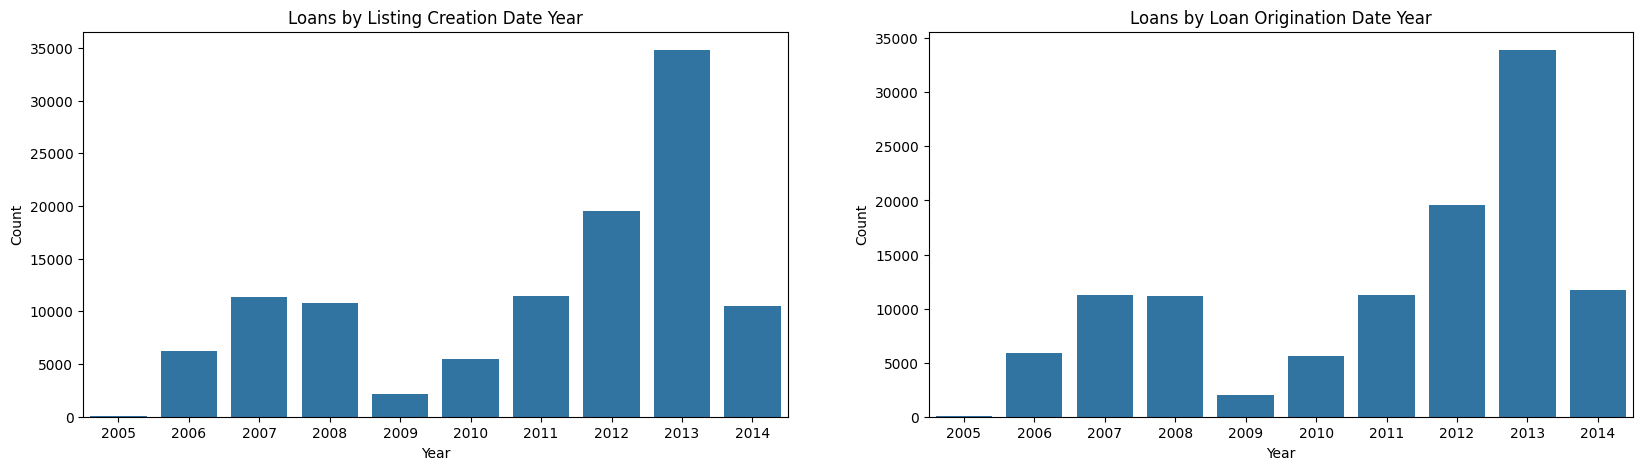

In [87]:
plt.figure(figsize = [20, 5])

# ListingCreationDate subplot
plt.subplot(1, 2, 1) 
sns.countplot(
    x=prosper_load_data_clean_df.ListingCreationDate.dt.year,
    color=base_color
);
plt.xlabel("Year")
plt.ylabel("Count")
plt.title("Loans by Listing Creation Date Year")

# LoanOriginationDate subplot
plt.subplot(1, 2, 2) 
sns.countplot(
    x=prosper_load_data_clean_df.LoanOriginationDate.dt.year,
    color=base_color
);
plt.xlabel("Year")
plt.ylabel("Count")
plt.title("Loans by Loan Origination Date Year");

As you can see, the count plots are pretty comparable with a mode at year 2013. There's a huge dip in 2009 which might be due to the 2008 global financial crisis. We can't really comment on the value of 2014 as it is only a partial sample for that year. Let's focus now on the month of the year to see if there's higher activity on any of them.

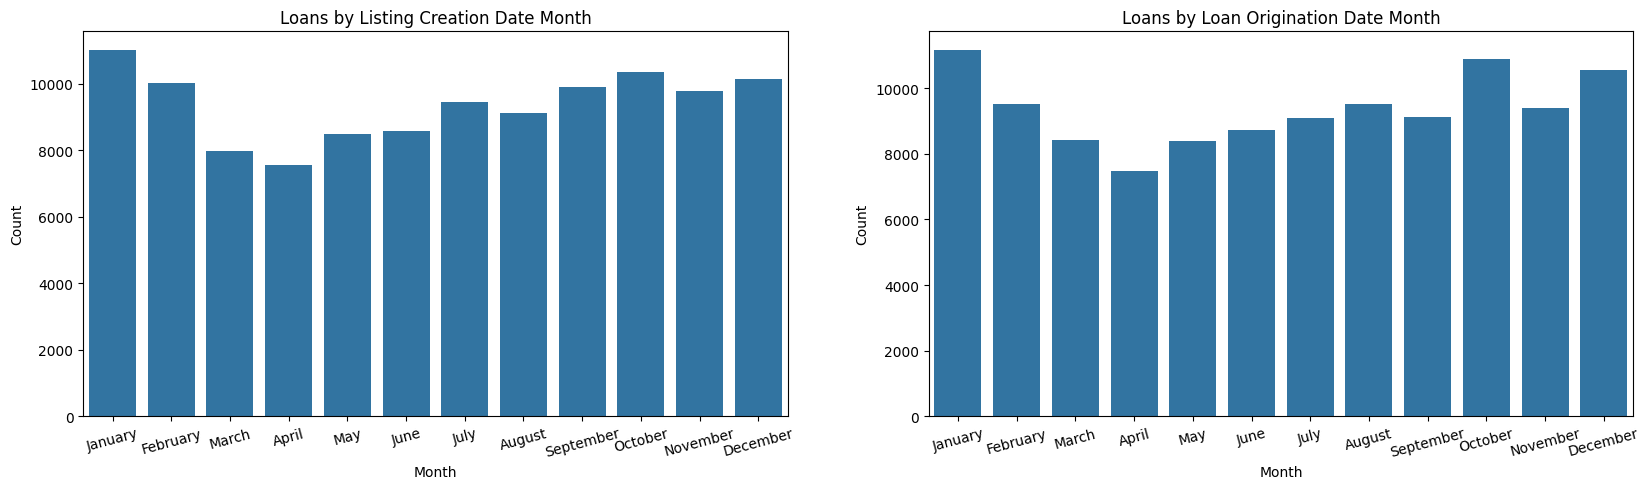

In [88]:
plt.figure(figsize = [20, 5])

month_names = list(map(lambda m: calendar.month_name[m], range(1, 13)))

# ListingCreationDate subplot
plt.subplot(1, 2, 1) 
sns.countplot(
    x=prosper_load_data_clean_df.ListingCreationDate.dt.month_name(),
    color=base_color,
    order=month_names
);
plt.xlabel("Month")
plt.xticks(rotation=15)
plt.ylabel("Count")
plt.title("Loans by Listing Creation Date Month")

# LoanOriginationDate subplot
plt.subplot(1, 2, 2) 
sns.countplot(
    x=prosper_load_data_clean_df.LoanOriginationDate.dt.month_name(),
    color=base_color,
    order=month_names
);
plt.xlabel("Month")
plt.xticks(rotation=15)
plt.ylabel("Count")
plt.title("Loans by Loan Origination Date Month");

Once again we see a similar distribution in both variables, but given the huge differences in the number of deals per year, it will be better if we explore the proportion of deals for each month for any given year.

In [89]:
def get_monthly_proportion_mean(df: pd.DataFrame, id_column: str, dt_column: str) -> pd.Series:
    """
    Computes the mean proportion for each month of every year
    """
    monthly_proportion_mean =  (
        df[id_column].groupby([                                       # Group by year/month
            prosper_load_data_clean_df[dt_column].dt.year,
            prosper_load_data_clean_df[dt_column].dt.month,           # We don't user month_name to avoid re-sorting
        ])
        .count()                                                      # Count loans of that year/month                                                   
        .groupby(
            level=0                                                   # Group by year
        ).apply(
            lambda x: x / x.sum()                                     # Compute proportion for each month
        ).groupby(
            level=1                                                   # Group by month
        ).mean()                                                      # Take the average
    )
    monthly_proportion_mean.index = monthly_proportion_mean.index.map(lambda m: calendar.month_name[m])
    return monthly_proportion_mean

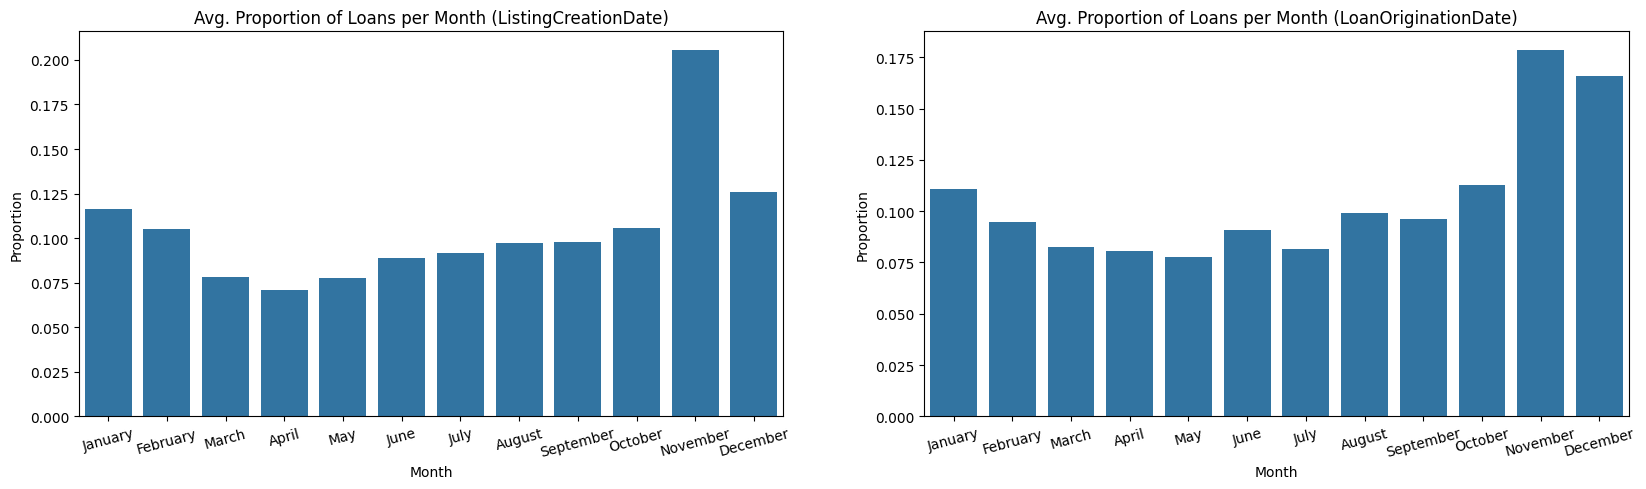

In [90]:
plt.figure(figsize=(20, 5))

monthly_proportion_mean_lcd = get_monthly_proportion_mean(
    prosper_load_data_clean_df,
    "ListingKey",
    "ListingCreationDate"
)

monthly_proportion_mean_lod = get_monthly_proportion_mean(
    prosper_load_data_clean_df,
    "ListingKey",
    "LoanOriginationDate"
)

# ListingCreationDate subplot
plt.subplot(1, 2, 1) 
sns.barplot(
    x=monthly_proportion_mean_lcd.index,
    y=monthly_proportion_mean_lcd.values,
    color=base_color
);
plt.xlabel("Month")
plt.xticks(rotation=15)
plt.ylabel("Proportion")
plt.title("Avg. Proportion of Loans per Month (ListingCreationDate)");

# LoanOriginationDate subplot
plt.subplot(1, 2, 2) 
sns.barplot(
    x=monthly_proportion_mean_lod.index,
    y=monthly_proportion_mean_lod.values,
    color=base_color
);
plt.xlabel("Month")
plt.xticks(rotation=15)
plt.ylabel("Proportion")
plt.title("Avg. Proportion of Loans per Month (LoanOriginationDate)");

Now the two charts do show some differences, but the dip around April remains.

Let's focus now on

* How are the borrower APR, borrower rate and lender yield related to each other?

Before we can attempt to answer this question, we need to look at the specific distribution of each variable. Being all numeric continuos variables, histograms are going to provide the answers we need.

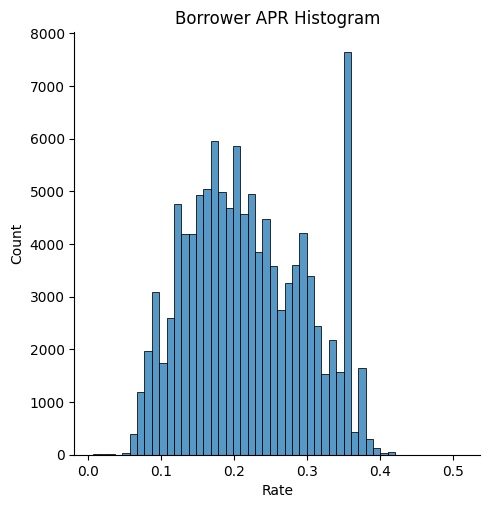

In [91]:
sns.displot(
    prosper_load_data_clean_df.BorrowerAPR,
    kind="hist",
    bins=50
)
plt.xlabel("Rate")
plt.title("Borrower APR Histogram");

The chart clearly shows a multimodal distribution. Let's tighten the limits a little bit.

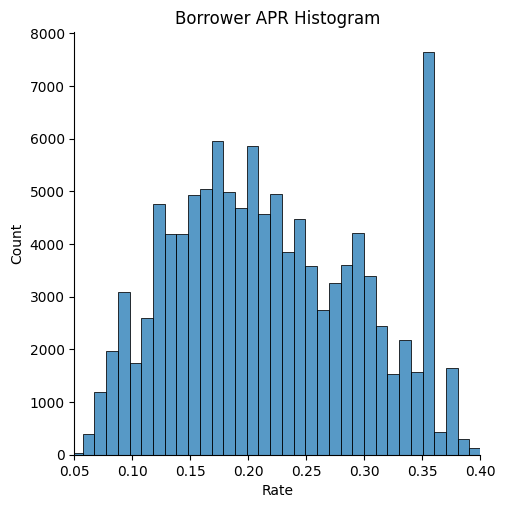

In [92]:
sns.displot(
    prosper_load_data_clean_df.BorrowerAPR,
    kind="hist",
    bins=50
)
plt.xlabel("Rate")
plt.xlim(0.05, 0.4)
plt.title("Borrower APR Histogram");

There are peaks between 0.05, and 0.1, between 0.1 and 0.15, around 0.2, around 0.3 and a huge spike aorund 0.35. Let's focus on those segments. Let's try plotting the Kernel Density Estimation: 

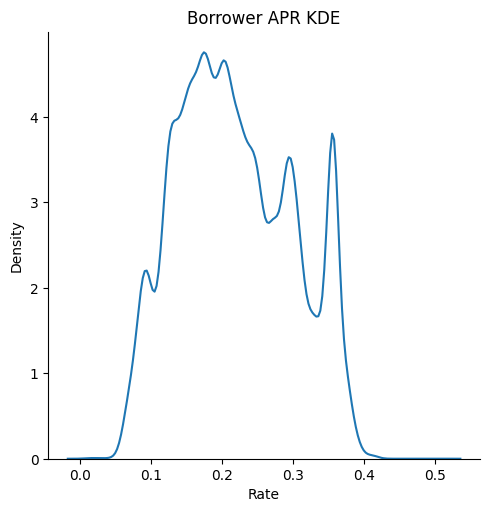

In [93]:
sns.displot(
    prosper_load_data_clean_df.BorrowerAPR,
    kind="kde"
);
plt.xlabel("Rate")
plt.title("Borrower APR KDE");

Now the peaks are more clearly shown. Maybe we're seing the influence of a categorical value the lumps interest rates around these peaks? Let's analyze the rest of the variables to see if there's something that might help explain this distribution.

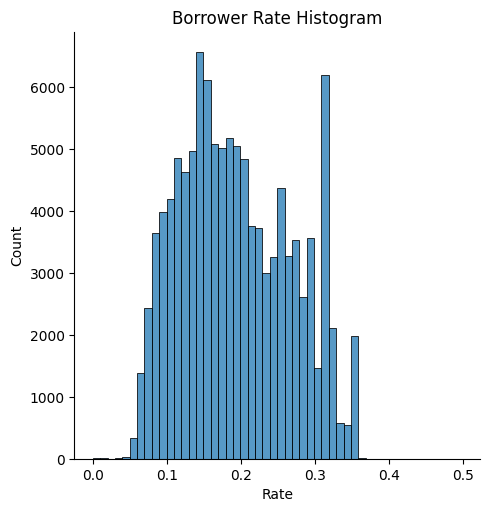

In [94]:
sns.displot(
    prosper_load_data_clean_df.BorrowerRate,
    kind="hist",
    bins=50
)
plt.xlabel("Rate")
plt.title("Borrower Rate Histogram");

This looks an awful lot like the ``BorrowerAPR`` histogram, but upon closer inspection, the peaks are not at the same places as they seem "shifted", which would be consistent with the definition of APR which includes the rate itself.

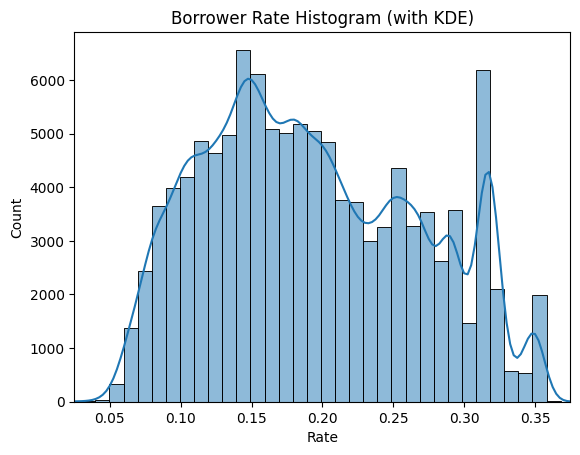

In [95]:
sns.histplot(
    prosper_load_data_clean_df.BorrowerRate,
    bins=50,
    kde=True
)
plt.title("Borrower Rate Histogram (with KDE)")
plt.xlabel('Rate')
plt.xlim(0.025, 0.375);

The plots are similar (multimodal) with peaks at different values (as expected). Let's look at ``LenderYield`` as well:

(0.025, 0.375)

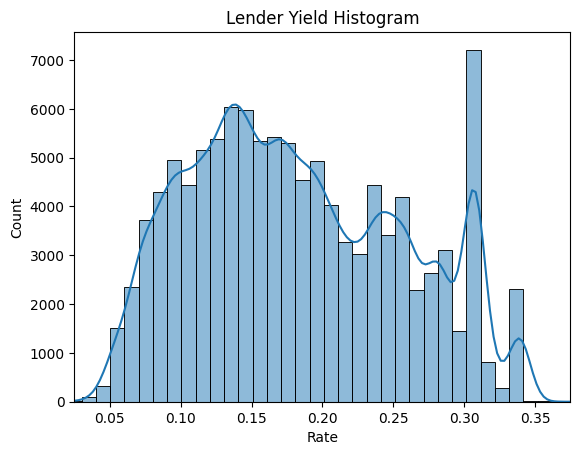

In [96]:
sns.histplot(
    prosper_load_data_clean_df.LenderYield,
    bins=50,
    kde=True
)
plt.title("Lender Yield Histogram");
plt.xlabel('Rate')
plt.xlim(0.025, 0.375)

We can see that the distributions of ``BorrowerRate`` and ``LenderYield`` are pretty similar.  We'll come back to these variables when we do multivariate analysis.

The answer to

* Which are the most popular loan categories?

can be easily shown with a simple bar chart:

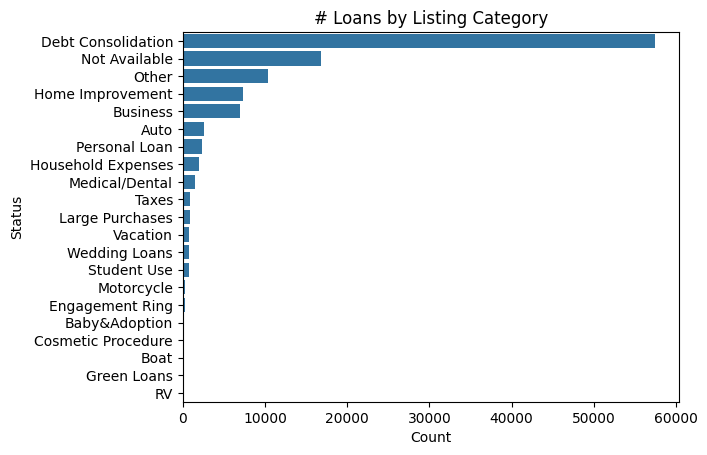

In [97]:
sns.countplot(
    y=prosper_load_data_clean_df.ListingCategory,
    color=base_color,
    order=prosper_load_data_clean_df.ListingCategory.value_counts().index
);
plt.xlabel("Count")
plt.ylabel("Status")
plt.title("# Loans by Listing Category");

The vast majority of deals are destined towards [debt consolidation](https://en.wikipedia.org/wiki/Debt_consolidation). The next two categories are "Not Available" and "Other" so any analysis of the influence of this variable on the APR is going to be limited. That being said, just the fact of showing that most of the loans are for debt consolidation is worth noting, but we need a chart that better reflects this fact:

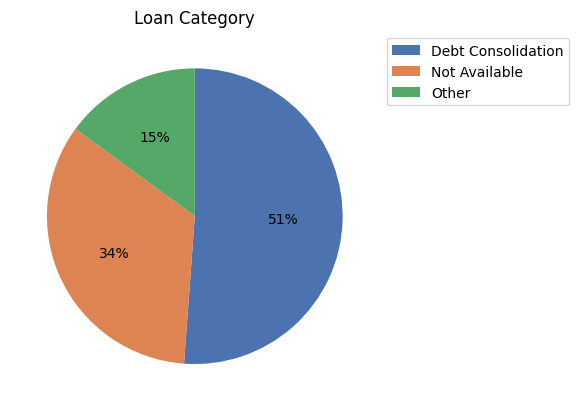

In [98]:
plt.pie(
    prosper_load_data_clean_df.ListingCategory.apply(
        lambda x: x if x in ("Debt Consolidation", "Not Available") else "Other"
    ).value_counts(),
    colors=sns.color_palette('deep'),
    startangle=90,
    counterclock=False,
    autopct='%.0f%%'
);
plt.legend(
    labels=("Debt Consolidation", "Not Available", "Other"),
    loc=2,
    bbox_to_anchor=(1, 1)
)
plt.title("Loan Category");

Before we can try to answer the question

* How does the employment status, occupation, home ownership, credit grades, income range and debt to income ratio affect the APR?

We need to analyse each variable in isolation to see if the available information allows us to do a significant analysis and if there are any notable patterns in the data. Let's start by analysis the credit grade variables.

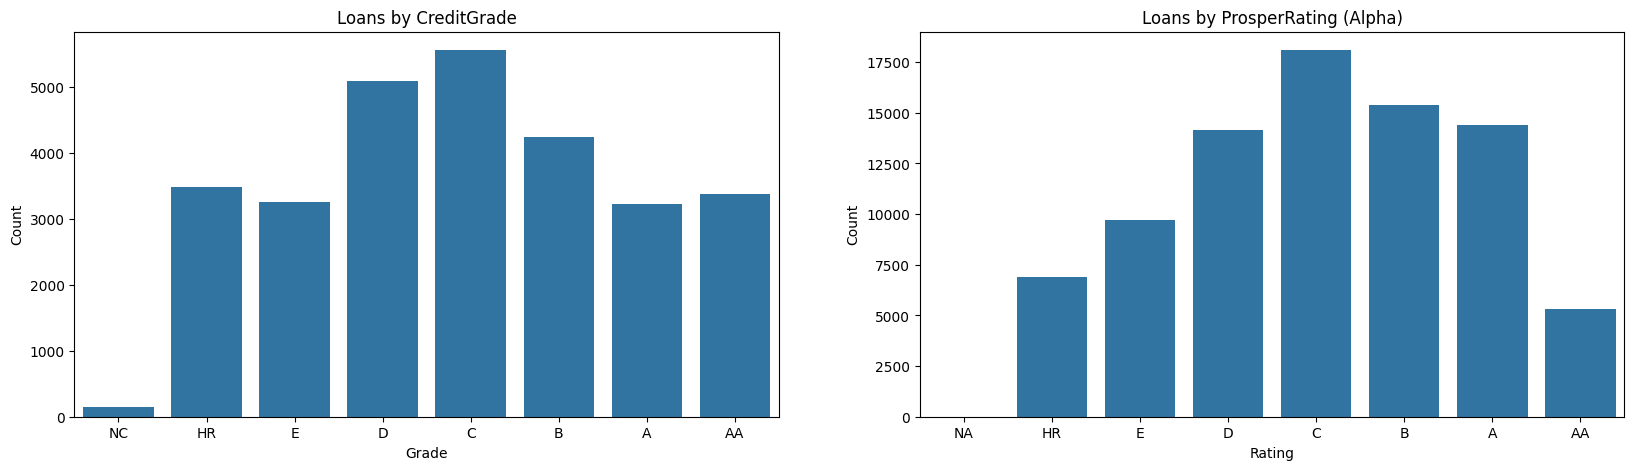

In [99]:
plt.figure(figsize=(20, 5))

# CreditGrade subplot
plt.subplot(1, 2, 1) 
sns.countplot(
    x=prosper_load_data_clean_df.CreditGrade,
    color=base_color
);
plt.xlabel("Grade")
plt.ylabel("Count")
plt.title("Loans by CreditGrade")

# ProsperRating (Alpha) subplot
plt.subplot(1, 2, 2) 
sns.countplot(
    x=prosper_load_data_clean_df["ProsperRating (Alpha)"],
    color=base_color
);
plt.xlabel("Rating")
plt.ylabel("Count")
plt.title("Loans by ProsperRating (Alpha)");

Notice that for both grading variables, the middling ranges are preferred. Usually people with a better credit rating are those that don't need to take loans at all. It's interesting that the number of loans with "AA" is comparable with those with "HR". Let's look a the ``Term`` now:

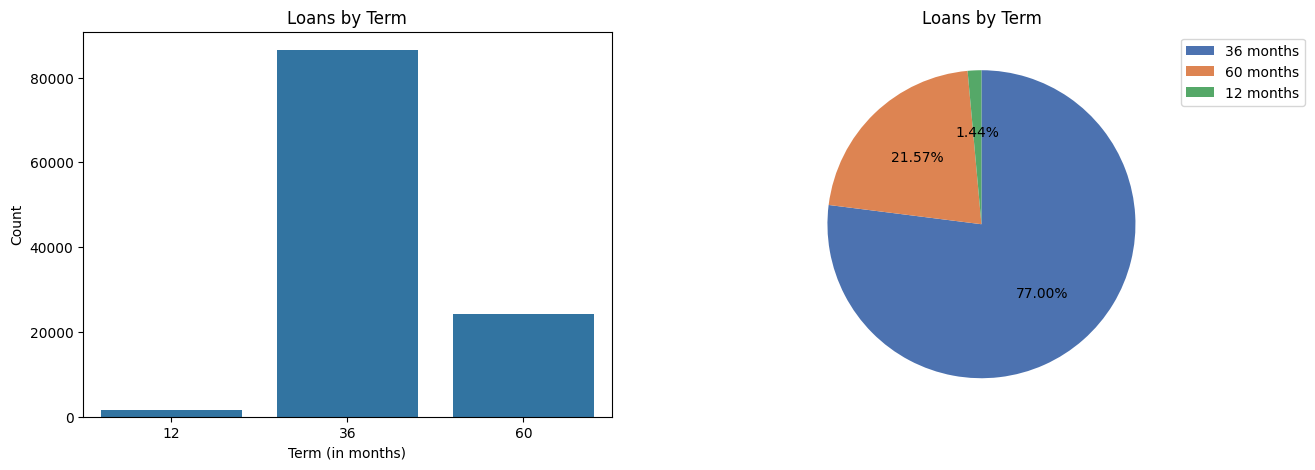

In [100]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1) 
sns.countplot(
    x=prosper_load_data_clean_df.Term,
    color=base_color
);
plt.xlabel("Term (in months)")
plt.ylabel("Count")
plt.title("Loans by Term");

term_value_counts = prosper_load_data_clean_df.Term.value_counts()

plt.subplot(1, 2, 2) 
plt.pie(
    term_value_counts,
    colors=sns.color_palette('deep'),
    startangle=90,
    counterclock=False,
    autopct='%.2f%%'
);
plt.legend(
    labels=term_value_counts.index.map(
        lambda x: f"{x} months"
    ),
    loc=2,
    bbox_to_anchor=(1, 1)
)
plt.title("Loans by Term");

Although both charts are represent the same facts, the piechart clearly shows that the overwhelming majority of loans are taken with a 36 month term.

I don't intend on showing specific charts about ``LoanStatus``, but the information will be useful when slicing the data set based on the categories.

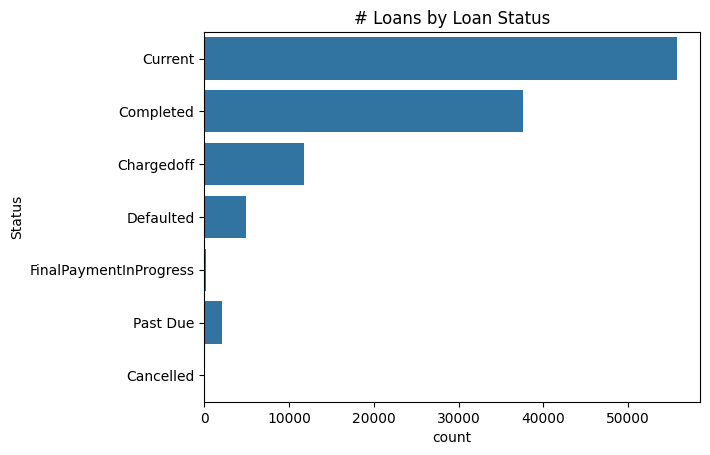

In [101]:
sns.countplot(
    y=prosper_load_data_clean_df.LoanStatus,
    color=base_color
);
plt.ylabel("Status")
plt.title("# Loans by Loan Status");

The most important information about this chart is that the number of loans that are "Defaulted" or "Past Due" are low, so any analysis on those specific subsets of loans will be limited. For instance, if we wanted to plot the the ``DelinquencyBucket`` for "Past Due" loans:

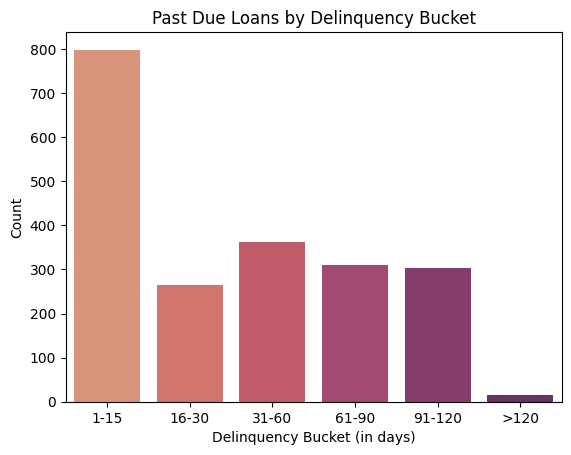

In [102]:
sns.countplot(
    x=prosper_load_data_clean_df[
        prosper_load_data_clean_df.LoanStatus == "Past Due"
    ].DelinquencyBucket,
    palette="flare"
);
plt.xlabel("Delinquency Bucket (in days)")
plt.ylabel("Count")
plt.title("Past Due Loans by Delinquency Bucket");

I chose a gradient palette to depict the increase in risk with each subsequent bucket. It's interesting to see that the 1-15 days period is predominant, but the rest are all comparable.

Now let's look at the employment related variables.

In [103]:
prosper_load_data_clean_df.Occupation.nunique()

67

There are 67 possible values for ``Occupation``, so any plot for categorical values will be hard to understand no matter the design. Let's look instead at the 10 most popular values for ``Ocupation`` instead:

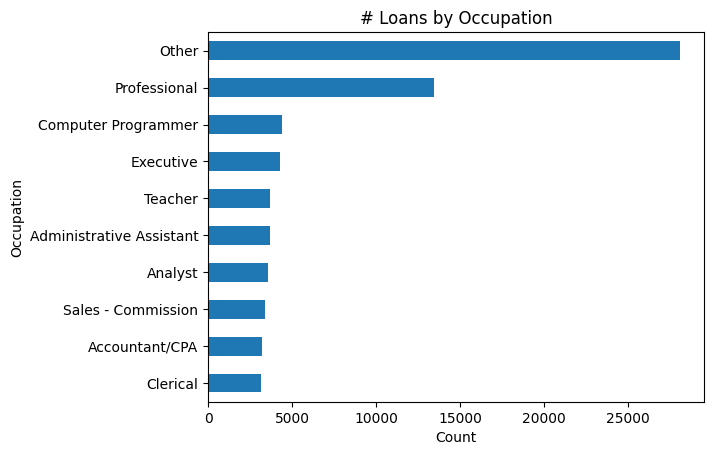

In [104]:
prosper_load_data_clean_df.Occupation.value_counts().head(10).sort_values().plot(
    kind="barh",
    color=base_color
);
plt.xlabel("Count")
plt.ylabel("Occupation")
plt.title("# Loans by Occupation");

Having "Other" as the most popular category is not goin to be very useful, so we'll drop this variable from our analysis. Let's check the ``EmploymentStatus`` instead:

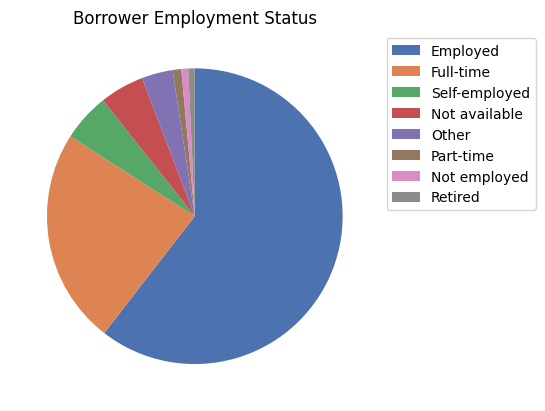

In [105]:
plt.pie(
    prosper_load_data_clean_df.EmploymentStatus.value_counts(),
    colors=sns.color_palette('deep'),
    startangle=90,
    counterclock=False
);
plt.legend(
    labels=prosper_load_data_clean_df.EmploymentStatus.value_counts().index,
    loc=2,
    bbox_to_anchor=(1, 1)
)
plt.title("Borrower Employment Status");

The sheer number of categories and the bias towards the "Other" value would complicate subsequent analysis as with the ``Ocupation`` variable. Also, there's no clear definition of the relationship between the ``Employed``, ``Full-time`` and ``Part-time`` category. Maybe we can consolidate all of these into a single ``Employed`` category to show that most borrowers are in fact employed. The chart is also a bit hard to parse, so we'll improve the readability as well.

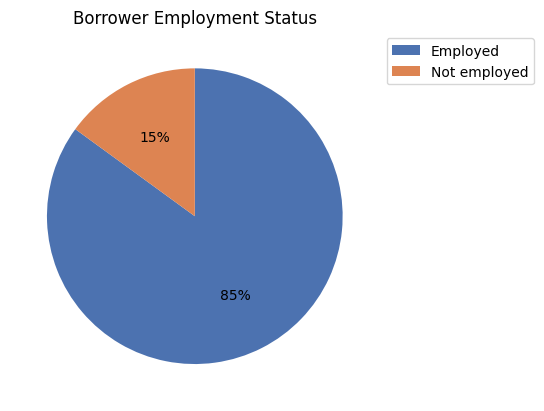

In [106]:
plt.pie(
    prosper_load_data_clean_df.EmploymentStatus.apply(
        lambda x: "Employed" if x in ("Employed", "Full-time", "Part-time") else "Not employed"
    ).value_counts(),
    colors=sns.color_palette('deep'),
    startangle=90,
    counterclock=False,
    autopct='%.0f%%'
);
plt.legend(
    labels=("Employed", "Not employed"),
    loc=2,
    bbox_to_anchor=(1, 1)
)
plt.title("Borrower Employment Status");

I think this chart more clearly shows the relative proportion of employed against non employed borrowers.

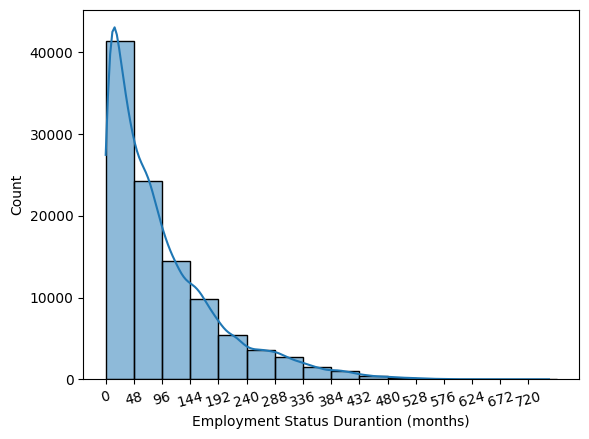

In [107]:
sns.histplot(
    prosper_load_data_clean_df.EmploymentStatusDuration,
    binwidth=48,
    kde=True
);
plt.xlabel("Employment Status Durantion (months)");
plt.xticks(np.arange(0, 768, 48))
plt.xticks(rotation=15);

The chart shows a clearly right skewed distribution, which means that loans are primarily taken by people with fewer months on jobs. The issue with this chart is that it's hard for people to think in terms of months, so we'll plot the number of years instead:

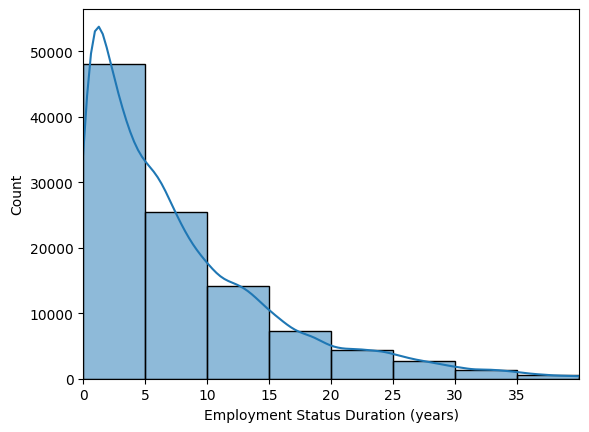

In [108]:
sns.histplot(
    np.round(prosper_load_data_clean_df.EmploymentStatusDuration / 12.0, 2),
    binwidth=5,
    kde=True
);
plt.xlabel("Employment Status Duration (years)")
plt.xticks(np.arange(0, 40, 5))
plt.xlim(0, 40);

This chart shows the same distribution, but it's a bit easier to parse. Finally let's analyze the income related variables:

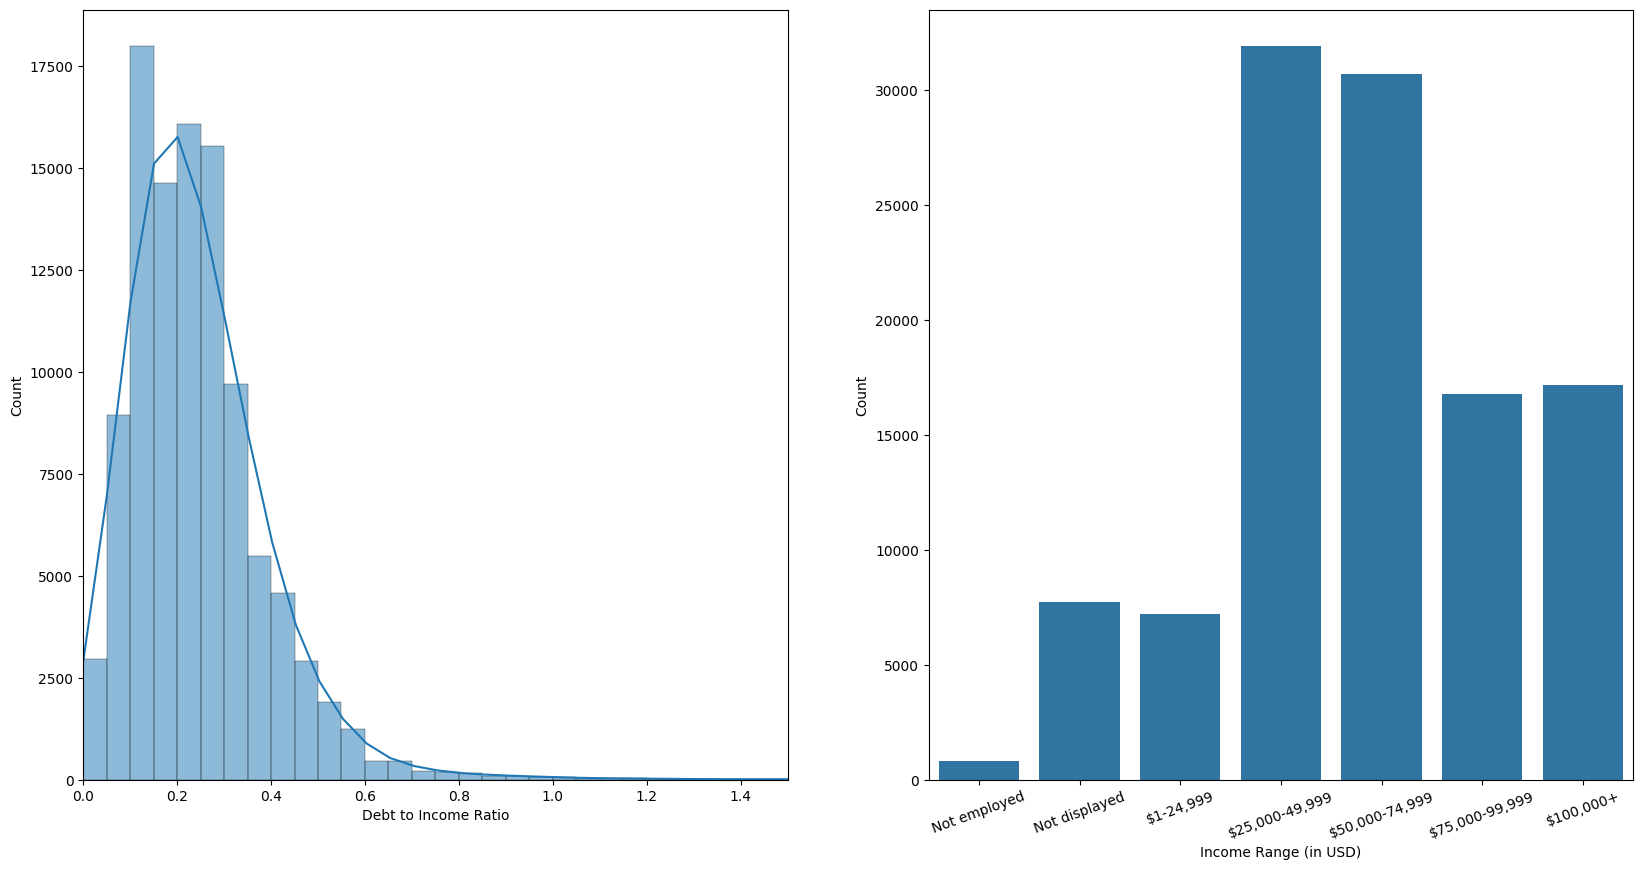

In [109]:
plt.figure(figsize=(20, 10))

plt.subplot(1, 2, 1)
sns.histplot(
    prosper_load_data_clean_df.DebtToIncomeRatio,
    binwidth=0.05,
    kde=True
);
plt.xlim(0,1.5);
plt.xlabel("Debt to Income Ratio")

plt.subplot(1, 2, 2)
sns.countplot(
    x=prosper_load_data_clean_df.IncomeRange,
    color=base_color
);
plt.xlabel("Income Range (in USD)")
plt.xticks(rotation=20);
plt.ylabel("Count");

The debt to income ratio seems to have a right skewed unimodal distribution with a mean around 0.28 (which means the debt is around 30% of the income) while mid-level income ranges are the most populous, but the highest income ranges also represent a hugh proportion of the population.

The answer to

* How many borrowers are home owners?

can be shown with a simple pie chart:

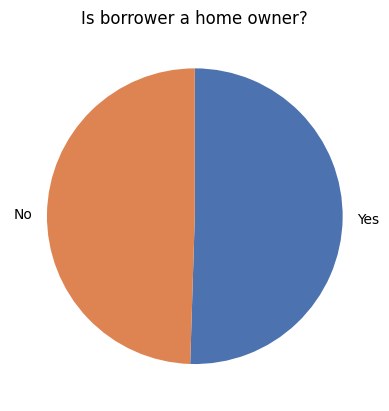

In [110]:
plt.pie(
    prosper_load_data_clean_df.IsBorrowerHomeowner.apply(
        lambda x: "Yes" if x else "No"
    ).value_counts(),
    colors=sns.color_palette('deep'),
    labels=("Yes", "No"),
    startangle=90,
    counterclock=False
);
plt.title("Is borrower a home owner?");

Half the borrowers are homeowners! We only had to transform the column slightly as "True", "False" are not very user friendly.

Finally, in order to answer

* Is there a relationship between the loan amount and the income range?

We first need to analyze the income range (which we've done before), and the loan amount.

In [111]:
prosper_load_data_clean_df.LoanOriginalAmount.describe()

count    112314.000000
mean       8324.573784
std        6234.488919
min        1000.000000
25%        4000.000000
50%        6404.500000
75%       12000.000000
max       35000.000000
Name: LoanOriginalAmount, dtype: float64

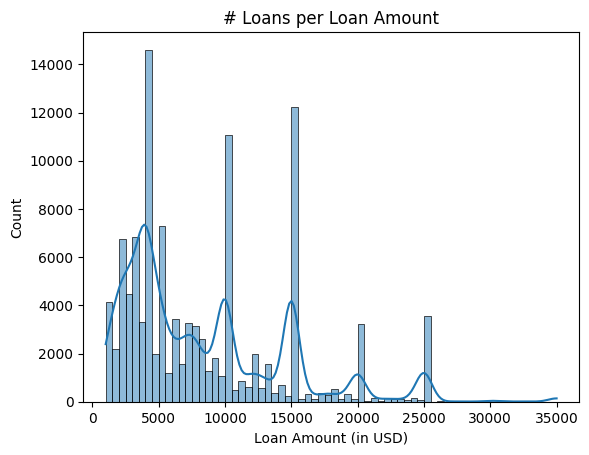

In [112]:
sns.histplot(
    prosper_load_data_clean_df.LoanOriginalAmount,
    bins=np.arange(1000, 30000, 500),
    kde=True
);
plt.xlabel("Loan Amount (in USD)")
plt.title("# Loans per Loan Amount");

It seems that the round numbers (500, 1000, 1500, 5000, 10000, 15000, etc.) are more popular that the number in between. Let's analyse the histogram without these values:

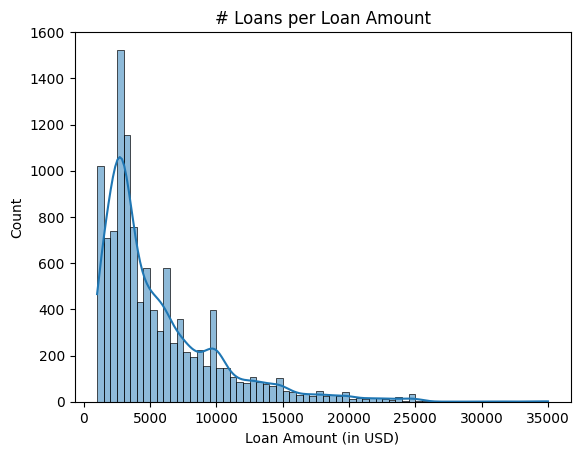

In [113]:
sns.histplot(
    prosper_load_data_clean_df.LoanOriginalAmount[
        prosper_load_data_clean_df.LoanOriginalAmount % 500 != 0  # No "round" number loan amounts
    ],
    bins=np.arange(1000, 35000, 500),
    kde=True
);
plt.xlabel("Loan Amount (in USD)")
plt.title("# Loans per Loan Amount");

This time the chart shows a right skewed distribution.

### Discuss the distribution(s) of your variable(s) of interest. Were there any unusual points? Did you need to perform any transformations?

> Your answer here!

### Of the features you investigated, were there any unusual distributions? Did you perform any operations on the data to tidy, adjust, or change the form of the data? If so, why did you do this?

> Your answer here!

## Bivariate Exploration<a class="anchor" id="bivariate-exploration"></a>

> In this section, investigate relationships between pairs of variables in your
data. Make sure the variables that you cover here have been introduced in some
fashion in the previous section (univariate exploration).

### Talk about some of the relationships you observed in this part of the investigation. How did the feature(s) of interest vary with other features in the dataset?

> Your answer here!

### Did you observe any interesting relationships between the other features (not the main feature(s) of interest)?

> Your answer here!

## Multivariate Exploration

> Create plots of three or more variables to investigate your data even
further. Make sure that your investigations are justified, and follow from
your work in the previous sections.

### Talk about some of the relationships you observed in this part of the investigation. Were there features that strengthened each other in terms of looking at your feature(s) of interest?

> Your answer here!

### Were there any interesting or surprising interactions between features?

> Your answer here!

## Conclusions
>You can write a summary of the main findings and reflect on the steps taken during the data exploration.



> Remove all Tips mentioned above, before you convert this notebook to PDF/HTML


> At the end of your report, make sure that you export the notebook as an
html file from the `File > Download as... > HTML or PDF` menu. Make sure you keep
track of where the exported file goes, so you can put it in the same folder
as this notebook for project submission. Also, make sure you remove all of
the quote-formatted guide notes like this one before you finish your report!

